<a href="https://colab.research.google.com/github/mitali-g/MachineLearning/blob/master/Squeeze_Net_Chest_Xray_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Input, GlobalAveragePooling2D, BatchNormalization, concatenate
from keras.utils import np_utils
import os, cv2, random
import pandas as pd
%matplotlib inline

In [111]:
!rm -r __MACOSX/Resized_Dataset

In [102]:
!unzip -q NEW_Resized_Dataset.zip

replace Resized_Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Resized_Dataset/Chest_xray_Corona_Metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Resized_Dataset/test-equalized/person82_bacteria_403.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Resized_Dataset/test-equalized/person1642_virus_2842.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Resized_Dataset/test-equalized/NORMAL2-IM-0370-0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [145]:
!ls Resized_Dataset/train-equalized|wc

   5291    5291  137110


In [169]:
dataset = pd.read_csv("Resized_Dataset/Chest_xray_Corona_Metadata.csv")
print(dataset.shape)
dataset[:5282]

(5906, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5277,5304,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,TRAIN,COVID-19,Virus
5278,5305,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,TRAIN,COVID-19,Virus
5279,5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5280,5307,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,TRAIN,COVID-19,Virus


In [170]:
dataset = dataset[['X_ray_image_name', 'Label']]

In [171]:
x_train_features = dataset[['X_ray_image_name']]
x_train_features = x_train_features[0:5282]
#print(x_train_features)

In [172]:
y_train_labels = dataset[['Label']]
y_train_labels = y_train_labels[0:5282]
#print(y_train_labels)

In [173]:
from sklearn.utils import shuffle
train_dataset = dataset[0:5282]
test_dataset = dataset[5282:]

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

In [174]:
x_train_features = train_dataset['X_ray_image_name']
y_train_labels = train_dataset['Label']

In [175]:
y_train = []
for label in y_train_labels:
  if label == 'Pnemonia':
    y_train.append(1)
  elif label == 'Normal':
    y_train.append(0)
  else:
    print(label)
#print(y_train)
y_train = keras.utils.to_categorical(y_train)
print(y_train)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [176]:
x_test_features = dataset[['X_ray_image_name']]
x_test_features = x_test_features[5282:]
#print(x_test_features)

In [177]:
y_test_labels = dataset[['Label']]
y_test_labels = y_test_labels[5282:]
#print(y_test_labels)

x_test_features = test_dataset['X_ray_image_name']
y_test_labels = test_dataset['Label']

In [178]:
import os
list_of_images = os.listdir('Resized_Dataset/train-equalized')
len(list_of_images)

5291

In [179]:
y_test = []
for label in y_test_labels:
  if label == 'Pnemonia':
    y_test.append(1)
  elif label == 'Normal':
    y_test.append(0)
  else:
    print(label)
#print(y_test)
y_test = keras.utils.to_categorical(y_test)
print(y_test)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


5282

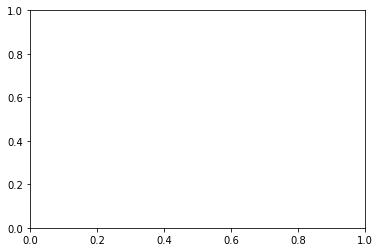

In [187]:
x_train = []
test_path = ('Resized_Dataset/train-equalized/')

for image in x_train_features:
  if ('.jpg' in image) == True:
        image = image[:image.rfind('.jpg')]
  elif ('.jpeg' in image) == True:
        image = image[:image.rfind('.jpeg')]
  elif ('.png' in image) == True:
        image = image[:image.rfind('.png')]
  image_path = test_path + image
  if os.path.isfile(image_path + '.png'):
    image = plt.imread(image_path + '.png')
    plt.grid(False)
    x_train.append(image)
len(x_train)

624

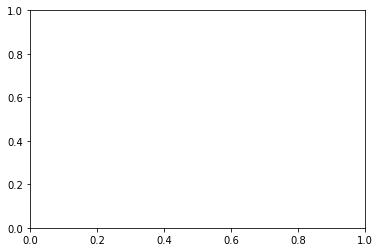

In [188]:
x_test = []

test_path = ('Resized_Dataset/test-equalized/')

for image in x_test_features:
  # image.rfind : removes '.jpeg'
  image_path =test_path + image[:image.rfind('.jpeg')]

  if os.path.isfile(image_path + '.png'):
    image = plt.imread(image_path + '.png')
    plt.grid(False)
    # plt.imshow(image)
    # plt.show()
    x_test.append(image)
len(x_test)

In [189]:
x_train = np.array(x_train, np.float16) / 255.0
y_train = np.array(y_train)
print(len(x_train), len(y_train), x_train.shape, y_train.shape)

x_test = np.array(x_test, np.float16) / 255.0
y_test = np.array(y_test)
print(len(x_test), len(y_test), x_test.shape, y_test.shape)

5282 5282 (5282, 256, 256) (5282, 2)
624 624 (624, 256, 256) (624, 2)


In [203]:
# https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb
# https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet/#6 
bnmomentum=0.9
def fire(x, squeeze, expand):
  y = Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
  y = BatchNormalization(momentum=bnmomentum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y1 = BatchNormalization(momentum=bnmomentum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  y3 = BatchNormalization(momentum=bnmomentum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)
x = Input(shape=[256, 256, 1])
#y = fire_module(squeeze=16, expand=64)(x) # squeeze is less than expand
#y = fire_module(squeeze=16, expand=64)(y)


y = Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = BatchNormalization(momentum=bnmomentum)(y)
y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 96)(y)
y = MaxPooling2D(pool_size=2)(y)
# y = fire_module(24, 128)(y)
# y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 96)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = GlobalAveragePooling2D()(y)
y = Dense(2, activation='softmax')(y)
model = tf.keras.Model(x, y)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 256, 256, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 256, 256, 32) 128         conv2d_108[0][0]                 
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 256, 256, 24) 792         batch_normalization_106[0][0]    
____________________________________________________________________________________________

In [204]:
validation_split = 0.25
history = model.fit(x_train, y_train, epochs = 5, validation_split=validation_split)

Epoch 1/5
124/124 [==============================] - 52s 418ms/step - loss: 0.3172 - accuracy: 0.8844 - val_loss: 1.2981 - val_accuracy: 0.7456
Epoch 2/5
124/124 [==============================] - 51s 414ms/step - loss: 0.1670 - accuracy: 0.9450 - val_loss: 9.1989 - val_accuracy: 0.2544
Epoch 3/5
124/124 [==============================] - 51s 414ms/step - loss: 0.1522 - accuracy: 0.9412 - val_loss: 8.2076 - val_accuracy: 0.7456
Epoch 4/5
124/124 [==============================] - 51s 414ms/step - loss: 0.1330 - accuracy: 0.9508 - val_loss: 0.1165 - val_accuracy: 0.9553
Epoch 5/5
124/124 [==============================] - 51s 414ms/step - loss: 0.1136 - accuracy: 0.9588 - val_loss: 0.1066 - val_accuracy: 0.9546


20/20 [==============================] - 2s 116ms/step - loss: 0.9468 - accuracy: 0.7115
0.9467970728874207 0.7115384340286255


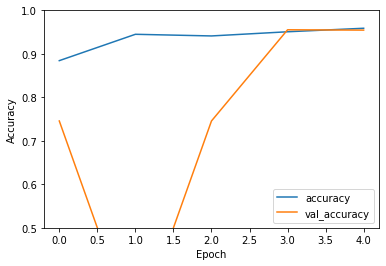

In [205]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test)
print(test_loss, test_acc)